In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def set_state(self, x, y, θ0, θ1, ϕ):
        self.x = x
        self.y = y
        self.θ0 = θ0
        self.θ1 = θ1
        self.ϕ = ϕ
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


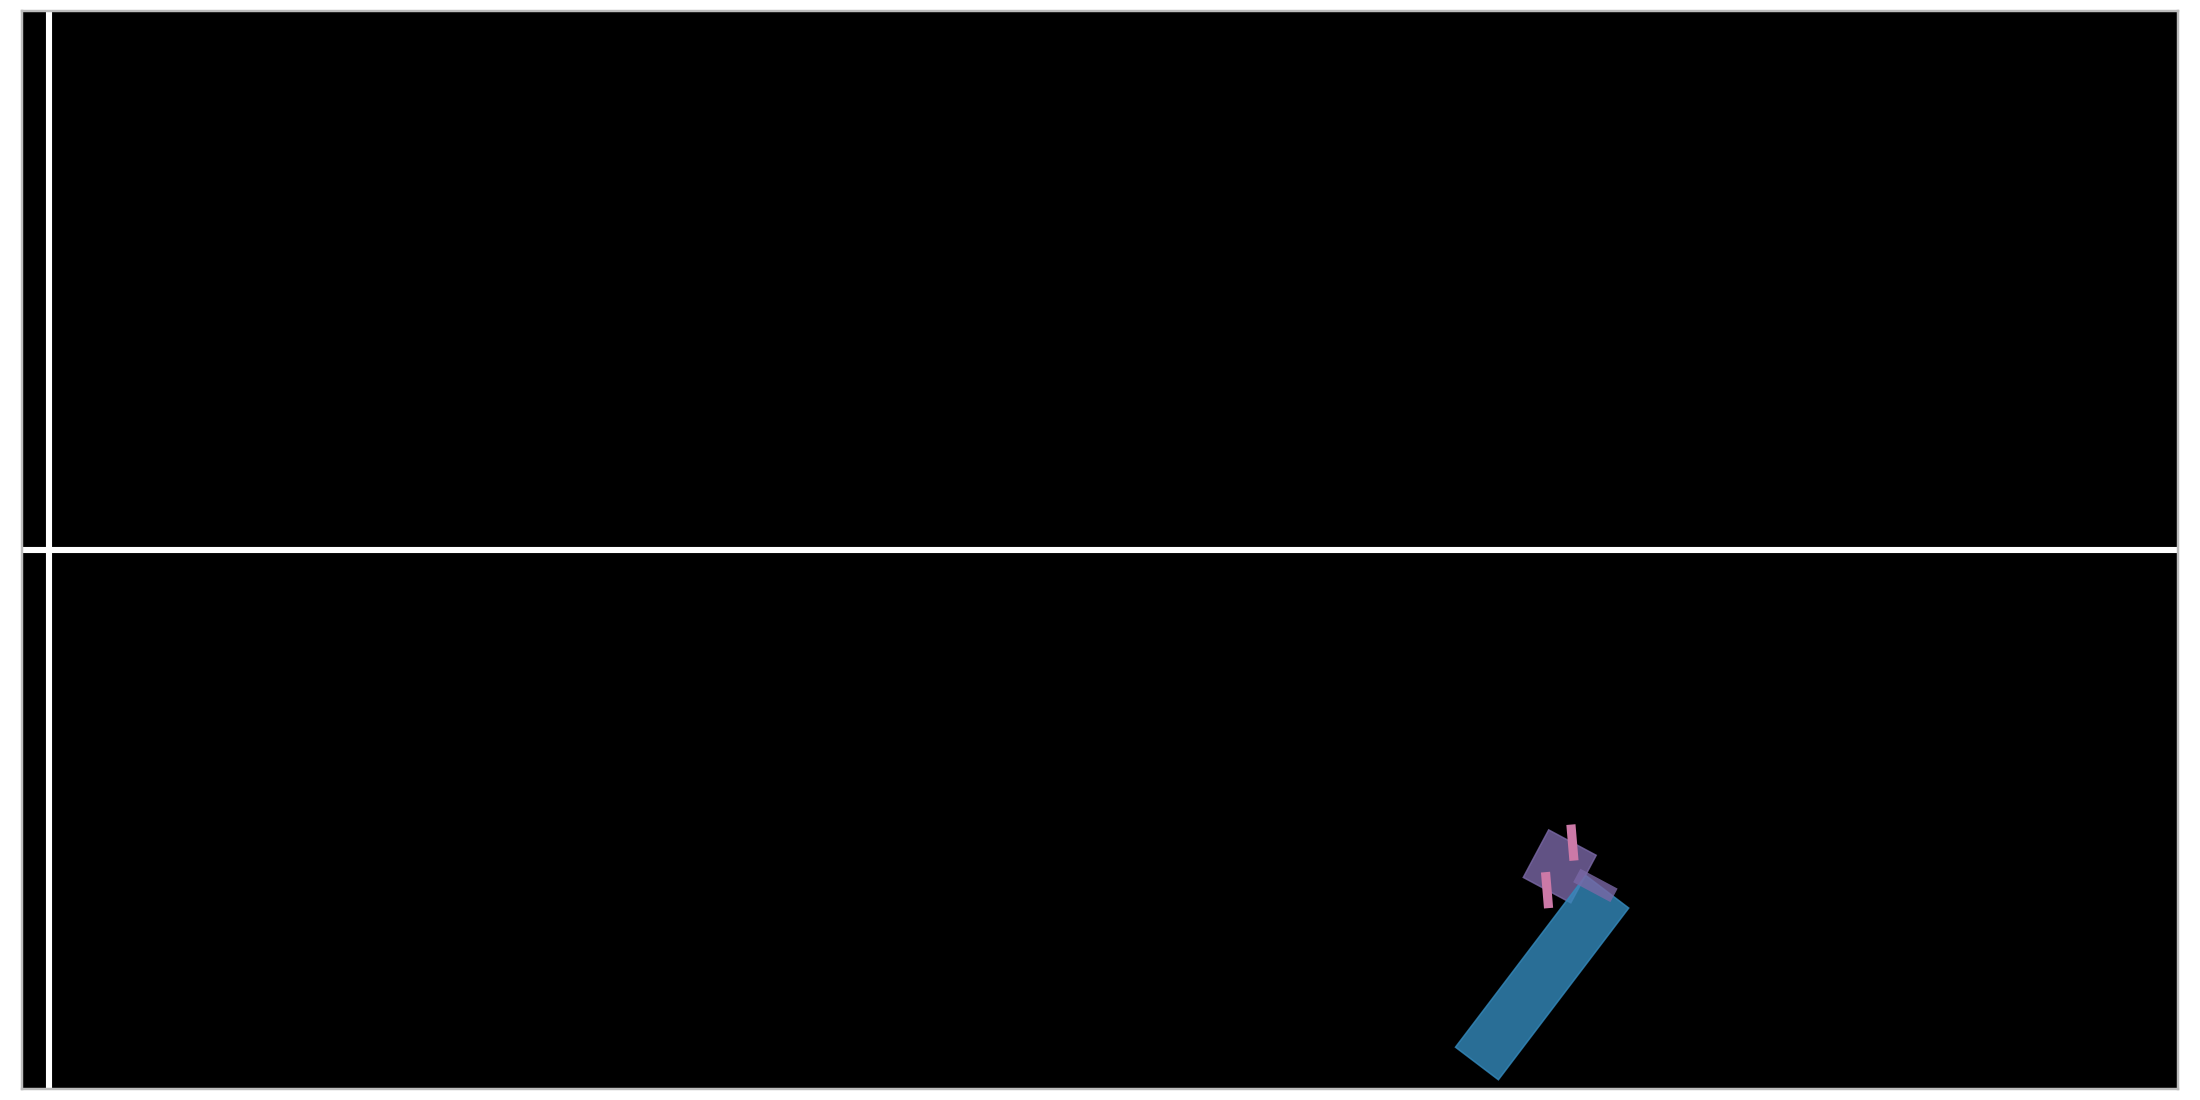

In [4]:
truck = Truck(display=True)

In [5]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

In [6]:
truck.reset()

In [7]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm

In [8]:
# Build expert data set

episodes = 100
inputs = list()
outputs = list()
# truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████| 100/100 [06:17<00:00,  2.52s/it]


In [9]:
len(inputs), len(outputs)

(6333, 6333)

In [10]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [11]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [12]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [13]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

6333 5066


In [14]:
len(train_inputs)

5066

In [15]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?

cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 5066, 0.3256002069
1000 / 5066, 0.0194033161
2000 / 5066, 0.0519264862
3000 / 5066, 0.0307124238
4000 / 5066, 0.0137890754
5000 / 5066, 0.0232800432


In [16]:
# Test
total_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

    
print(f'Test loss: {loss.item():.10f}')

Test loss: 0.0210352354


In [17]:
hidden_units_c = 25

controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size)
)

optimiser_c = SGD(controller.parameters(), lr=0.005)

In [18]:
controller.train()
emulator.train()

for epoch in tqdm(range(50)):
    truck.reset() # selecting a random truck position, we want to park it to the dock
    truck.draw()
    target_state = torch.tensor([truck.d, 0, 0, 0, 0, 0], dtype=torch.float)
    target_state = (target_state - mean[1:]) / std[1:]
    curr_state = truck.state()
    cnt = 0
    prev_loss = None
    print("epoch {} done...".format(epoch))
    while truck.valid():
        curr_state = torch.tensor([*curr_state])
        ϕ_pred = controller(curr_state)
        pred_state = emulator(torch.tensor([ϕ_pred, *curr_state]))
        loss = criterion(pred_state[4:], target_state[4:]) + criterion(pred_state[5], pred_state[2]) + criterion(pred_state, curr_state)
        
        optimiser_c.zero_grad()
        loss.backward()
        optimiser_c.step()
        
        curr_state = pred_state
        
        ϕ = (ϕ_pred[0]*std[0]) + mean[0]
        state = (pred_state*std[0]) + mean[0]
        ϕ = ϕ.detach().numpy()
        state = state.detach().numpy()
        truck.set_state(state[0], state[1], state[2], state[5], ϕ)
        
        truck.draw()
        
        curr_state = pred_state
        
        if prev_loss is not None and abs(loss.item()-prev_loss) < 0.001:
            break
        prev_loss = loss.item()
        
        if cnt == 0 or (cnt + 1) % 100 == 0:
            print(f'{cnt + 1:4d} :, {loss.item():.10f} ϕ: {ϕ: 0.4f} θ0(pred): {pred_state[2]: 0.4f} θ1(pred): {pred_state[5]: 0.4f} θ0: {truck.θ0: 0.4f} θ1: {truck.θ1: 0.4f}')
        cnt += 1

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 0 done...
   1 :, 15.4766216278 ϕ:  0.9229 θ0(pred): -1.5904 θ1(pred):  0.4096 θ0: -0.7176 θ1:  0.1856


  4%|▍         | 2/50 [00:01<00:47,  1.01it/s]

epoch 1 done...
   1 :, 63.1485252380 ϕ:  2.4148 θ0(pred): -2.5969 θ1(pred):  3.4275 θ0: -1.1722 θ1:  1.5487


  6%|▌         | 3/50 [00:01<00:35,  1.33it/s]

epoch 2 done...
   1 :, 60.7975959778 ϕ:  2.0352 θ0(pred):  1.1141 θ1(pred):  5.4827 θ0:  0.5038 θ1:  2.4769
epoch 3 done...


  8%|▊         | 4/50 [00:02<00:29,  1.56it/s]

   1 :, 24.2831878662 ϕ:  1.0904 θ0(pred):  2.6138 θ1(pred):  4.3265 θ0:  1.1811 θ1:  1.9547


 10%|█         | 5/50 [00:02<00:22,  1.97it/s]

epoch 4 done...
   1 :, 86.5678787231 ϕ:  1.6397 θ0(pred):  2.6187 θ1(pred):  6.9439 θ0:  1.1833 θ1:  3.1368
epoch 5 done...


 12%|█▏        | 6/50 [00:02<00:18,  2.39it/s]

   1 :, 42.9227523804 ϕ:  1.6068 θ0(pred):  0.2042 θ1(pred):  4.3804 θ0:  0.0929 θ1:  1.9790
epoch 6 done...
   1 :, 36.3021507263 ϕ:  1.2043 θ0(pred):  3.1603 θ1(pred):  5.5907 θ0:  1.4280 θ1:  2.5256


 16%|█▌        | 8/50 [00:03<00:17,  2.41it/s]

epoch 7 done...
   1 :, 55.9263381958 ϕ:  1.6724 θ0(pred):  1.9497 θ1(pred):  5.6161 θ0:  0.8812 θ1:  2.5371
epoch 8 done...


 18%|█▊        | 9/50 [00:03<00:14,  2.86it/s]

   1 :, 46.4883956909 ϕ:  2.2188 θ0(pred): -4.2035 θ1(pred):  1.2948 θ0: -1.8978 θ1:  0.5854
epoch 9 done...


 20%|██        | 10/50 [00:03<00:12,  3.27it/s]

   1 :, 18.9894447327 ϕ:  1.3906 θ0(pred): -3.4319 θ1(pred):  0.1582 θ0: -1.5494 θ1:  0.0721
epoch 10 done...


 22%|██▏       | 11/50 [00:04<00:11,  3.43it/s]

   1 :, 71.3903808594 ϕ:  2.4809 θ0(pred): -0.8739 θ1(pred):  4.9067 θ0: -0.3940 θ1:  2.2167
epoch 11 done...
   1 :, 45.9537925720 ϕ:  0.9050 θ0(pred):  3.4876 θ1(pred):  5.7239 θ0:  1.5758 θ1:  2.5858


 26%|██▌       | 13/50 [00:05<00:15,  2.46it/s]

epoch 12 done...
   1 :, 82.4467468262 ϕ:  2.7158 θ0(pred): -0.8293 θ1(pred):  4.7019 θ0: -0.3739 θ1:  2.1242
epoch 13 done...


 30%|███       | 15/50 [00:05<00:10,  3.41it/s]

   1 :, 79.9009399414 ϕ:  1.4102 θ0(pred):  2.0476 θ1(pred):  5.6657 θ0:  0.9254 θ1:  2.5595
epoch 14 done...
   1 :, 26.9012908936 ϕ:  1.6802 θ0(pred): -3.8049 θ1(pred):  0.5031 θ0: -1.7178 θ1:  0.2279


 32%|███▏      | 16/50 [00:05<00:08,  3.80it/s]

epoch 15 done...
   1 :, 48.3986549377 ϕ:  1.9742 θ0(pred):  0.8131 θ1(pred):  4.4466 θ0:  0.3679 θ1:  2.0089
epoch 16 done...


 34%|███▍      | 17/50 [00:05<00:07,  4.20it/s]

   1 :, 53.8346939087 ϕ:  2.1090 θ0(pred):  0.1446 θ1(pred):  4.5404 θ0:  0.0659 θ1:  2.0513
epoch 17 done...
   1 :, 39.5153884888 ϕ:  1.6603 θ0(pred):  1.9304 θ1(pred):  5.0676 θ0:  0.8725 θ1:  2.2894


 38%|███▊      | 19/50 [00:06<00:10,  3.00it/s]

epoch 18 done...
   1 :, 16.0024986267 ϕ:  0.8506 θ0(pred): -0.3977 θ1(pred):  0.9685 θ0: -0.1790 θ1:  0.4381
epoch 19 done...
   1 :, 29.7659873962 ϕ:  1.3269 θ0(pred): -0.9336 θ1(pred):  1.5959 θ0: -0.4210 θ1:  0.7214


 40%|████      | 20/50 [00:08<00:20,  1.45it/s]

epoch 20 done...
   1 :, 22.8110580444 ϕ:  1.0168 θ0(pred):  3.2751 θ1(pred):  4.7667 θ0:  1.4798 θ1:  2.1535


 44%|████▍     | 22/50 [00:09<00:13,  2.00it/s]

epoch 21 done...
   1 :, 38.6878509521 ϕ:  1.5650 θ0(pred):  1.8481 θ1(pred):  5.2347 θ0:  0.8353 θ1:  2.3649


 46%|████▌     | 23/50 [00:09<00:11,  2.29it/s]

epoch 22 done...
   1 :, 39.2203483582 ϕ:  1.6316 θ0(pred):  0.0661 θ1(pred):  4.1895 θ0:  0.0305 θ1:  1.8928
epoch 23 done...
   1 :, 30.1510200500 ϕ:  0.9211 θ0(pred):  3.0922 θ1(pred):  5.1444 θ0:  1.3972 θ1:  2.3241


 48%|████▊     | 24/50 [00:09<00:12,  2.07it/s]

epoch 24 done...
   1 :, 34.4409217834 ϕ:  1.5019 θ0(pred): -2.3426 θ1(pred):  0.6042 θ0: -1.0574 θ1:  0.2735


 50%|█████     | 25/50 [00:12<00:24,  1.02it/s]

epoch 25 done...
   1 :, 65.7326583862 ϕ:  1.0751 θ0(pred):  3.6773 θ1(pred):  6.1082 θ0:  1.6615 θ1:  2.7593


 52%|█████▏    | 26/50 [00:13<00:24,  1.03s/it]

epoch 26 done...
   1 :, 55.4751319885 ϕ:  1.7714 θ0(pred):  2.3541 θ1(pred):  4.9736 θ0:  1.0639 θ1:  2.2469


 54%|█████▍    | 27/50 [00:13<00:20,  1.13it/s]

epoch 27 done...
   1 :, 32.5917625427 ϕ:  1.0551 θ0(pred):  2.5694 θ1(pred):  4.9316 θ0:  1.1611 θ1:  2.2280


 56%|█████▌    | 28/50 [00:14<00:17,  1.25it/s]

epoch 28 done...
   1 :, 30.3360328674 ϕ:  1.2824 θ0(pred):  1.6299 θ1(pred):  4.4551 θ0:  0.7368 θ1:  2.0128


 58%|█████▊    | 29/50 [00:15<00:15,  1.35it/s]

epoch 29 done...
   1 :, 53.6477508545 ϕ:  1.0295 θ0(pred):  3.3862 θ1(pred):  5.6053 θ0:  1.5300 θ1:  2.5322


 62%|██████▏   | 31/50 [00:16<00:12,  1.56it/s]

epoch 30 done...
   1 :, 38.6410980225 ϕ:  1.5575 θ0(pred):  0.2931 θ1(pred):  4.2400 θ0:  0.1330 θ1:  1.9156
epoch 31 done...
   1 :, 37.5028648376 ϕ:  0.9374 θ0(pred):  1.4570 θ1(pred):  4.0698 θ0:  0.6587 θ1:  1.8387


 64%|██████▍   | 32/50 [00:16<00:11,  1.56it/s]

epoch 32 done...
   1 :, 33.8507804871 ϕ:  0.6916 θ0(pred):  2.1919 θ1(pred):  3.8133 θ0:  0.9906 θ1:  1.7229


 66%|██████▌   | 33/50 [00:17<00:11,  1.47it/s]

epoch 33 done...
   1 :, 30.4507141113 ϕ:  1.2006 θ0(pred):  3.4776 θ1(pred):  5.5674 θ0:  1.5713 θ1:  2.5151


 68%|██████▊   | 34/50 [00:18<00:09,  1.62it/s]

epoch 34 done...
   1 :, 36.4608497620 ϕ:  0.9696 θ0(pred):  2.0022 θ1(pred):  4.4440 θ0:  0.9049 θ1:  2.0078


 72%|███████▏  | 36/50 [00:18<00:06,  2.05it/s]

epoch 35 done...
   1 :, 50.4073257446 ϕ:  1.8397 θ0(pred): -1.2572 θ1(pred):  2.3616 θ0: -0.5672 θ1:  1.0673
epoch 36 done...


 76%|███████▌  | 38/50 [00:19<00:03,  3.03it/s]

   1 :, 62.0270423889 ϕ:  2.2920 θ0(pred):  0.7750 θ1(pred):  4.8728 θ0:  0.3507 θ1:  2.2014
epoch 37 done...
   1 :, 37.9399795532 ϕ:  1.7274 θ0(pred): -0.5839 θ1(pred):  3.5016 θ0: -0.2631 θ1:  1.5821


 78%|███████▊  | 39/50 [00:19<00:03,  3.33it/s]

epoch 38 done...
   1 :, 83.8187866211 ϕ:  2.1140 θ0(pred):  0.8243 θ1(pred):  5.8503 θ0:  0.3729 θ1:  2.6429
epoch 39 done...
   1 :, 25.7137546539 ϕ:  0.8656 θ0(pred): -1.5244 θ1(pred): -0.4528 θ0: -0.6878 θ1: -0.2039


 82%|████████▏ | 41/50 [00:21<00:04,  1.86it/s]

epoch 40 done...
   1 :, 27.2438087463 ϕ:  1.5385 θ0(pred): -1.8228 θ1(pred):  2.2192 θ0: -0.8226 θ1:  1.0029
epoch 41 done...
   1 :, 26.1436977386 ϕ:  1.2494 θ0(pred):  0.3441 θ1(pred):  3.4966 θ0:  0.1561 θ1:  1.5798


 86%|████████▌ | 43/50 [00:22<00:03,  2.01it/s]

epoch 42 done...
   1 :, 66.1965408325 ϕ:  2.2972 θ0(pred):  0.3303 θ1(pred):  5.1496 θ0:  0.1498 θ1:  2.3264
epoch 43 done...
   1 :, 28.0918350220 ϕ:  0.9056 θ0(pred):  3.2434 θ1(pred):  4.9968 θ0:  1.4655 θ1:  2.2574


 88%|████████▊ | 44/50 [00:23<00:03,  1.72it/s]

epoch 44 done...
   1 :, 41.3665313721 ϕ:  1.3234 θ0(pred):  1.0912 θ1(pred):  2.9845 θ0:  0.4935 θ1:  1.3486


 92%|█████████▏| 46/50 [00:23<00:01,  2.20it/s]

epoch 45 done...
   1 :, 49.2366867065 ϕ:  2.1199 θ0(pred): -3.8519 θ1(pred):  1.5451 θ0: -1.7390 θ1:  0.6985
epoch 46 done...
   1 :, 36.5692710876 ϕ:  0.7132 θ0(pred):  3.7500 θ1(pred):  5.2133 θ0:  1.6943 θ1:  2.3552


 94%|█████████▍| 47/50 [00:25<00:02,  1.48it/s]

epoch 47 done...
   1 :, 38.8144760132 ϕ:  0.8229 θ0(pred):  3.0551 θ1(pred):  4.8364 θ0:  1.3805 θ1:  2.1850


 96%|█████████▌| 48/50 [00:25<00:01,  1.34it/s]

epoch 48 done...
   1 :, 68.3218917847 ϕ:  1.1117 θ0(pred):  3.3334 θ1(pred):  6.0466 θ0:  1.5061 θ1:  2.7316


 98%|█████████▊| 49/50 [00:27<00:00,  1.18it/s]

epoch 49 done...
   1 :, 54.1695098877 ϕ:  1.1534 θ0(pred):  2.4693 θ1(pred):  5.2487 θ0:  1.1159 θ1:  2.3712


100%|██████████| 50/50 [00:27<00:00,  1.20it/s]


In [19]:
# Test the controller
# It should smoothly park the truck
controller.eval()
emulator.eval()

for simulation in range(20):
    truck.reset()
    truck.draw()
    while truck.valid():
        curr_state = truck.state()
        ϕ_pred = controller(torch.tensor([*curr_state]))
        ϕ = (ϕ_pred[0]*std[0]) + mean[0]
        truck.step(ϕ.detach().numpy())
        truck.draw()